# Getting Started with the Iguazio Data Science Platform

## Step 1: Installation and Setup

For information on how to install and configure MLRun over Kubernetes, see the MLRun [installation guide](../install.md).
To install the MLRun package, run `pip install mlrun` with the MLRun version that matches your MLRun service.

> **For Iguazio Data Science Platform Users**<br>
> If your are using the Iguazio Data Science Platform, MLRun is available as a default (pre-deployed) shared service.<br>
> You can run `!/User/align_mlrun.sh` to install the MLRun package or upgrade the version of an installed package.
> By default, the script attempts to download the latest version of the MLRun Python package that matches the version of the running MLRun service.

> **Kernel Restart**<br>
> After installing or updating the MLRun package, restart the notebook kernel in your environment!

In [1]:
!/User/align_mlrun.sh

Both server & client are aligned (0.6.2).


### Initializing Your MLRun Environment

MLRun projects are used for packaging multiple runs, functions, workflows, and artifacts.
Projects are created when you run a job or save an object (such as a function or artifact) to a specific project.
For more information about MLRun project, see the MLRun [projects documentation](../projects.md).

Use the `set_environment` MLRun method to configure the working environment and default configuration. 
This method returns a tuple with the current project name and artifacts path.

Set the method's `project` parameter to your selected project name.
You can also optionally set the `user_project` parameter to `True` to automatically append the username of the running user to the project name specified in the `project` parameter, resulting in a `<project>-<username>` project name;
this is useful for avoiding project-name conflicts among different users.

You can optionally pass additional parameters to `set_environment`, as detailed in the MLRun API reference.
For example:
- You can set the `artifact_path` parameter to override the default path for storing project artifacts, as explained in the MLRun [artifacts documentation](../store/artifacts.md).
- When using a remote MLRun or Kubernetes cluster, you can set the `api_path` parameter to the URL of your remote environment, and set the `access_key` parameter to an authentication key for this environment.

Run the following code to initialize your MLRun environment to use a "getting-started-tutorial-&lt;username&gt;"
project and store the project artifacts in the default artifacts path:

In [2]:
from os import path
import mlrun

# Set the base project name
project_name_base = 'platform-demo'
# Initialize the MLRun environment and save the project name and artifacts path
project_name, artifact_path = mlrun.set_environment(project=project_name_base,
                                                    user_project=True)
                                                    
# Display the current project name and artifacts path
print(f'Project name: {project_name}')
print(f'Artifacts path: {artifact_path}')

Project name: platform-demo-admin
Artifacts path: v3io:///projects/{{run.project}}/artifacts


## Step 2: Creating a Basic Function

This step introduces you to MLRun functions and artifacts and walks you through the process of converting a local function to an MLRun function.

#### MLRun Function Code

The following code demonstrates how to redefine your local data-preparation function to make it compatible with MLRun, and then convert the local notebook code into an MLRun function.

In [3]:
# mlrun: start-code

In [4]:
import mlrun
def prep_data(context, source_url: mlrun.DataItem, label_column='label'):

    # Convert the DataItem to a pandas DataFrame
    df = source_url.as_df()
    df[label_column] = df[label_column].astype('category').cat.codes    
    
    # Record the DataFrane length after the run
    context.log_result('num_rows', df.shape[0])

    # Store the data set in your artifacts database
    context.log_dataset('cleaned_data', df=df, index=False, format='csv')

In [5]:
# mlrun: end-code

#### Converting the Notebook Code to a Function

Use the `# mlrun: ...` comment annotations at the beginning of relevant code cells to identify the code that needs to be converted into an MLRun function.
These annotations provide non-intrusive hints as to how you want to convert the notebook into a full function and function specification:

- The `# mlrun: ignore` annotation identifies code that shouldn't be included in the MLRun function (such as prints, plots, tests, and debug code).
- The `# mlrun: start-code` and `# mlrun: end-code` annotations identify code to be converted to an MLRun function:
    everything before the `start-code` annotation and after the `end-code` annotation is ignored, and only code between these two annotations is converted.
    These annotations are used in the tutorial notebook instead of adding the `ignore` annotation to all cells that shouldn't be converted.
    > **Note:** You can use the `mlrun: start-code` and `mlrun: end-code` annotations only once in a notebook.
    > If there are multiple uses, only the first use will be selected.

The following code uses the `code_to_function` MLRun method to convert your local `prep_data` function code to a `data_prep_func` MLRun function.

The `kind` parameter of the `code_to_function` method determines the engine for running the code.
MLRun allows running function code using different engines &mdash; such as Python, Spark, MPI, Nuclio, and Dask.
The following example sets the `kind` parameter to `job` to run the code as a Python process ("job").

In [6]:
# Convert the local prep_data function to an MLRun project function
data_prep_func = mlrun.code_to_function(name='prep_data', kind='job', image='mlrun/mlrun')

#### Running the MLRun Function Locally

Now you're ready to run your MLRun function (`data_prep_func`).
The following example uses the `run` MLRun method and sets its `local` parameter to `True` to run the function code locally within your Jupyter pod, meaning that the function uses the environment variables, volumes, and image that are running in this pod.

> **Note:** When running a function locally, the function code is saved only in a temporary local directory and not in your project's ML functions code repository.
> In the next step of this tutorial you'll run the function on a cluster, which automatically saves the function object in the project.

The execution results are stored in the MLRun database.
The tutorial example sets the following function parameters:

- `name` &mdash; the job name
- `handler` &mdash; the name of the function handler
- `input` &mdash; the data-set URL

As input for the function, the example uses a CSV file from a cloud object-store service named wasabisys.
> **Note:** You can also use the function to ingest data in other formats than CSV, such as Parquet, without modifying the code.

In [7]:
# Set the source-data URL
source_url = 'https://s3.wasabisys.com/iguazio/data/iris/iris.data.raw.csv'

In [8]:
# Run the `data_prep_func` MLRun function locally
prep_data_run = data_prep_func.run(name='prep_data',
                                   handler=prep_data,
                                   inputs={'source_url': source_url},
                                   local=True)

> 2021-04-07 08:32:29,020 [info] starting run prep_data uid=4867d48fb4b14fa894d54ce8dc589fc7 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
platform-demo-admin,...dc589fc7,0,Apr 07 08:32:29,completed,prep_data,v3io_user=adminkind=owner=adminhost=jupyter-759dfb75d8-s26k4,source_url,,num_rows=150,cleaned_data


to track results use .show() or .logs() or in CLI: 
!mlrun get run 4867d48fb4b14fa894d54ce8dc589fc7 --project platform-demo-admin , !mlrun logs 4867d48fb4b14fa894d54ce8dc589fc7 --project platform-demo-admin
> 2021-04-07 08:32:29,536 [info] run executed, status=completed


In [9]:
# example
prep_data_run.state()

'completed'

In [10]:
prep_data_run.outputs['cleaned_data']

'store://artifacts/platform-demo-admin/prep_data_cleaned_data:4867d48fb4b14fa894d54ce8dc589fc7'

## Step 3: Running the Function on a Cluster

You can also run MLRun functions on the cluster itself, as opposed to running them locally in the Jupyter pod, as done in the previous steps.
Running a function on the cluster allows you to leverage the cluster's resources and run a more resource-intensive workloads.
MLRun helps you to easily run your code without the hassle of creating configuration files and build images.
To run an MLRun function on a cluster, just change the value of the `local` flag in the call to the `run` method to `False`.

In [11]:
from mlrun.platforms import auto_mount

In [12]:
data_prep_func.apply(auto_mount())
prep_data_run = data_prep_func.run(name='prep_data',
                                   handler='prep_data',
                                   inputs={'source_url': source_url},
                                   local=False)

> 2021-04-07 08:32:29,585 [info] starting run prep_data uid=9ee9291eda4847369ecf7c54f4bc154d DB=http://mlrun-api:8080
> 2021-04-07 08:32:29,722 [info] Job is running in the background, pod: prep-data-8949n
> 2021-04-07 08:32:34,729 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
platform-demo-admin,...f4bc154d,0,Apr 07 08:32:34,completed,prep_data,v3io_user=adminkind=jobowner=adminhost=prep-data-8949n,source_url,,num_rows=150,cleaned_data


to track results use .show() or .logs() or in CLI: 
!mlrun get run 9ee9291eda4847369ecf7c54f4bc154d --project platform-demo-admin , !mlrun logs 9ee9291eda4847369ecf7c54f4bc154d --project platform-demo-admin
> 2021-04-07 08:32:35,827 [info] run executed, status=completed


In [13]:
print(prep_data_run.outputs)

{'num_rows': 150, 'cleaned_data': 'store://artifacts/platform-demo-admin/prep_data_cleaned_data:9ee9291eda4847369ecf7c54f4bc154d'}


<a id="gs-tutorial-1-step-ui-jobs-view"></a>

## Step 4: Viewing Jobs on the Dashboard (UI)

On the **Projects** dashboard page, select your project and then navigate to the project's jobs and workflow page by selecting the relevant link.
For this tutorial, after running the `prep_data` method twice, you should see three records with types local (**&lt;&gt;**) and job.
In this view you can track all jobs running in your project and view detailed job information.
Select a job name to display tabs with additional information such as an input data set, artifacts that were generated by the job, and execution results and logs. 

<img src="./images/jobs.png" alt="Jobs" width="800"/>

## Step 5: Data Exploration

Use the `import_function` MLRun method, which adds or updates a function object in a project, to load the `describe` MLRun marketplace function into a new `describe` project function. 
The tutorial code sets the first `import_function` parameter &mdash; `url` &mdash; which identities the function to load.

> **Note:** MLRun supports multiple types of URL formats.
> The example uses the `hub://<function name>` format to point to the `describe` function-code directory in the MLRun functions marketplace (`'hub://describe'`).
> You can add `:<tag>` to this syntax to load a specific function tag &mdash; `hub://<function_name>:<tag>`; replace the `<function name>` and `<tag>` placeholders with the desired function name and tag.

In [14]:
from mlrun.platforms import auto_mount
describe = mlrun.import_function('hub://describe').apply(auto_mount())

<a id="gs-tutorial-2-view-func-doc"></a>

### Viewing the Function Documentation

Use the `doc` method to view the embedded documentation of the `describe` function.

In [15]:
describe.doc()

function: describe
describe and visualizes dataset stats
default handler: summarize
entry points:
  summarize: Summarize a table
    context(MLClientCtx)  - the function context, default=
    table(DataItem)  - MLRun input pointing to pandas dataframe (csv/parquet file path), default=
    label_column(str)  - ground truth column label, default=None
    class_labels(List[str])  - label for each class in tables and plots, default=[]
    plot_hist(bool)  - (True) set this to False for large tables, default=True
    plots_dest(str)  - destination folder of summary plots (relative to artifact_path), default=plots
    update_dataset  - when the table is a registered dataset update the charts in-place, default=False


### Running the Exploration Function

Run the following code to execute the `describe` project function as a Kubernetes job by using the MLRun `run` method.
The returned run object is stored in a `describe_run` variable.

The location of the data set is the only input that you need to provide.
This information is provided as a `table` input artifact that points to the `table_set` output artifact of the `prep_data_run` job that you ran in the previous step.

In [16]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    prep_data_run.outputs['cleaned_data']})

> 2021-04-07 08:32:36,023 [info] starting run describe-summarize uid=22cf97b721f5416980bfc3c58b3c9470 DB=http://mlrun-api:8080
> 2021-04-07 08:32:36,200 [info] Job is running in the background, pod: describe-summarize-cfhnr
> 2021-04-07 08:34:27,318 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
platform-demo-admin,...8b3c9470,0,Apr 07 08:34:23,completed,describe-summarize,v3io_user=adminkind=jobowner=adminhost=describe-summarize-cfhnr,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 22cf97b721f5416980bfc3c58b3c9470 --project platform-demo-admin , !mlrun logs 22cf97b721f5416980bfc3c58b3c9470 --project platform-demo-admin
> 2021-04-07 08:34:35,718 [info] run executed, status=completed


### Reviewing the Run Output

The output cell for your code execution contains a run-information table.
You can also view run information in the MLRun dashboard; see the output-review information in Step 2, only this time look for the `describe-summarize` job and related artifacts.

The `describe` function generates three HTML output artifacts, which provide visual insights for your data set &mdash; `histograms`, `imbalance`, and `correlation`.
The artifacts are stored as HTML files in your project's artifacts directory, under **&lt;project artifacts path&gt;/jobs/plots/**.
The following code displays the artifact files in the notebook.


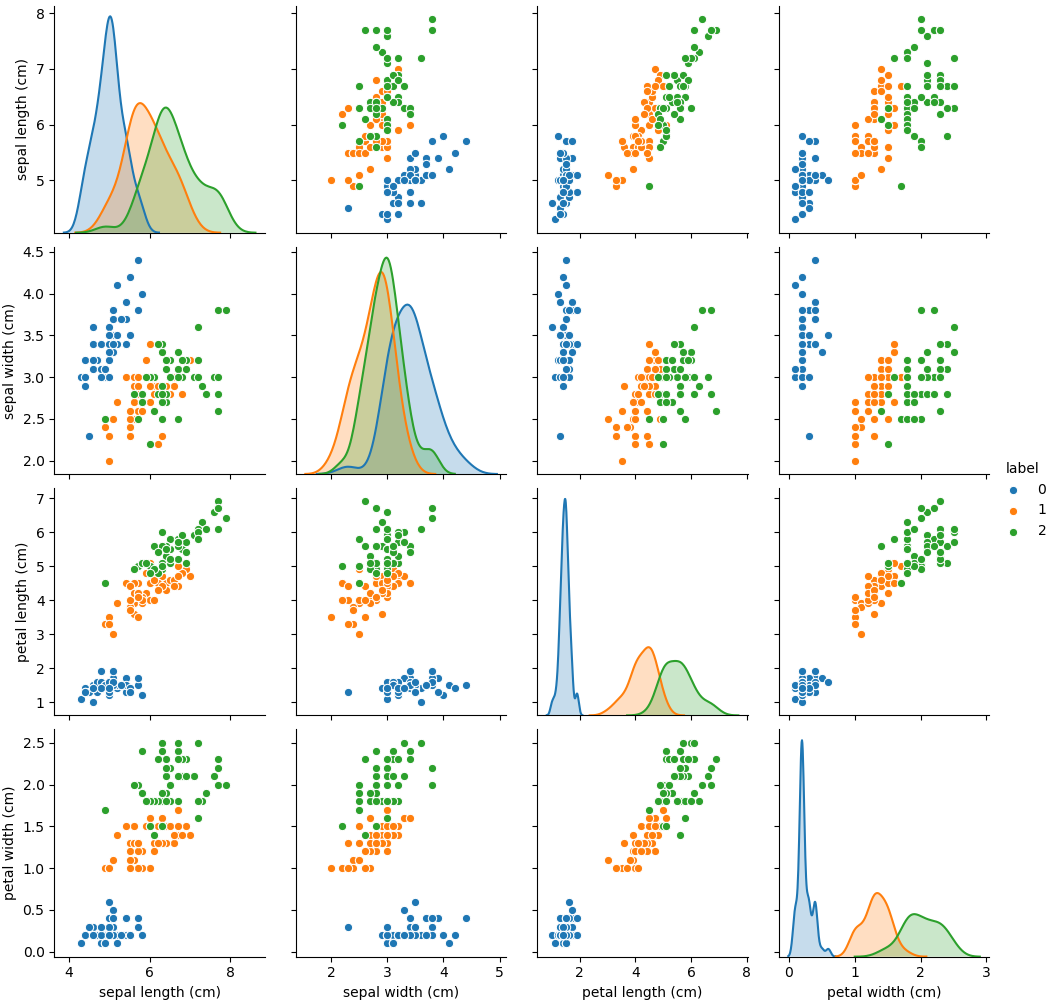

In [27]:
from IPython.display import display, HTML
def display_dataitem(dataitem):
    display(HTML(mlrun.get_dataitem(dataitem).get().decode('utf-8')))
# Display the `histograms` artifact
display_dataitem(describe_run.outputs['histograms'])


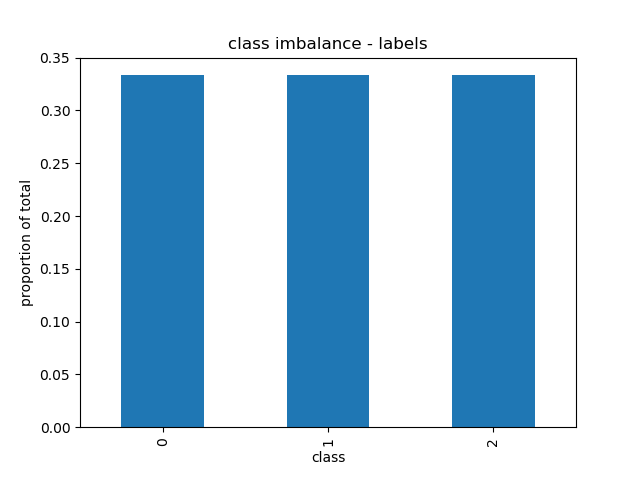

In [29]:
# Display the `imbalance` artifact
display_dataitem(describe_run.outputs['imbalance'])


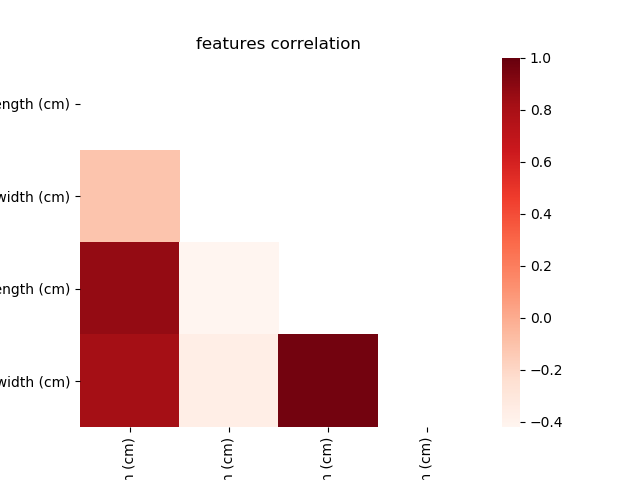

In [30]:
# Display the `correlation` artifact
display_dataitem(describe_run.outputs['correlation'])

## Step 6: Run Model Training at Scale

It's time to train your model.
Start by adding a training project function that uses the [`sklearn_classifier` MLRun marketplace function](https://github.com/mlrun/functions/tree/master/sklearn_classifier) to train three scikit-learn models; (you can use this function to train any scikit-learn model).
Then, use an MLRun task to run your function in order to train and evaluate the models and select the optimal model.

#### Add a Training Function

Run the following code to add to your project a `train` function that uses the `sklearn_classifier` marketplace function code, and create a related `train` function object.

In [22]:
train = mlrun.import_function('hub://sklearn_classifier').apply(auto_mount())

#### Run a Model-Training Task

The following code uses the MLRun `new_task` method to create a new `train` MLRun task and a related `train_task` task object for executing the `train` project function.
An MLRun **task** defines the parameters, inputs, and outputs of a logical job or task to execute.
The advantage of tasks is that they're independent of the runtime environment.
Hence, you can define a task once and use it in different scenarios.

The `NewTask` `inputs` parameter is set to the `iris_dataset` data set, as stored in the output artifacts of the previously executed `get_data` job.
The `test_size` training parameter (`params.test_size`) is set to 0.10.
This means that the `iris_dataset` data set will make up 90% of the training data set, and the remaining 10% will be the scikit-learn test data set.

The `train_task` task (and therefore the `train` function) is executed by using the `run` method.
The returned run object is stored in a `train_run` variable.

The code uses the `with_hyper_params` task method, which enables running multiple iterations of the same task with different parameter combinations, comparing the results, and selecting the optimal combination based on the specified selection criteria.
In this example, there's a single `models` parameter with different values (model names) so as to compare multiple models; the model with the most accurate training results is selected as the optimal model.
The `with_hyper_params` method receives the following parameters

- **`hyperparams`** &mdash; a dictionary of parameter names and parameter-values lists.
  The example defines a single hyperparameter named `model_pkg_class`, and sets its value to a `models` variable that contains a list of three scikit-learn models to train and evaluate. 
- **`selector`** &mdash; a string of the format `'<min/max>.<validation criterion>'`, which defines a selection criterion for selecting the winning run iteration.
  For example, `"max.accuracy"` selects the iteration with the most accurate results while `"min.loss"` selects the iteration with minimum loss.
  The example uses the `max.accuracy` selector to select the model with the most accurate training results.

In [23]:
# Configure the models to train
models = ["sklearn.ensemble.RandomForestClassifier", 
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

In [24]:
# Create a training task
train_task = mlrun.new_task(name="train",
                            params={"sample": -1,
                                    "label_column": "label",
                                    "test_size": 0.10},
                            inputs={"dataset": prep_data_run.outputs['cleaned_data']})

# Run the training task
train_run = train.run(train_task.with_hyper_params({'model_pkg_class': models},
                                                   selector='max.accuracy'),
                      artifact_path=artifact_path)

> 2021-04-07 08:38:47,189 [info] starting run train uid=a3168afae3104c9a891b0640f02b0aac DB=http://mlrun-api:8080
> 2021-04-07 08:38:47,366 [info] Job is running in the background, pod: train-dpnfq
> 2021-04-07 08:38:55,058 [info] best iteration=2, used criteria max.accuracy
> 2021-04-07 08:38:55,390 [info] run executed, status=completed
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
platform-demo-admin,...f02b0aac,0,Apr 07 08:38:51,completed,train,v3io_user=adminkind=jobowner=admin,dataset,sample=-1label_column=labeltest_size=0.1,best_iteration=2accuracy=0.975609756097561test-error=0.024390243902439025auc-micro=0.9973230220107079auc-weighted=0.9966358284272497f1-score=0.9721739130434783precision_score=0.9743589743589745recall_score=0.9722222222222222,test_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodeliteration_results


to track results use .show() or .logs() or in CLI: 
!mlrun get run a3168afae3104c9a891b0640f02b0aac --project platform-demo-admin , !mlrun logs a3168afae3104c9a891b0640f02b0aac --project platform-demo-admin
> 2021-04-07 08:38:56,524 [info] run executed, status=completed



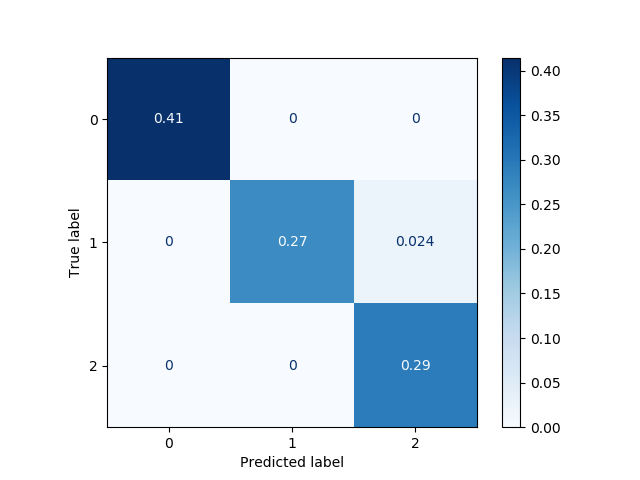


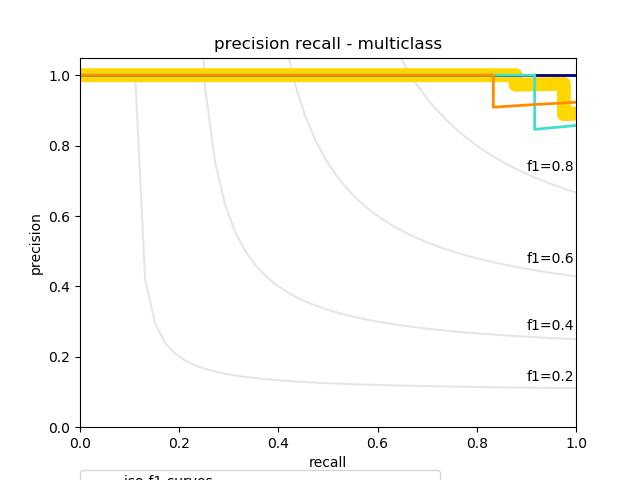


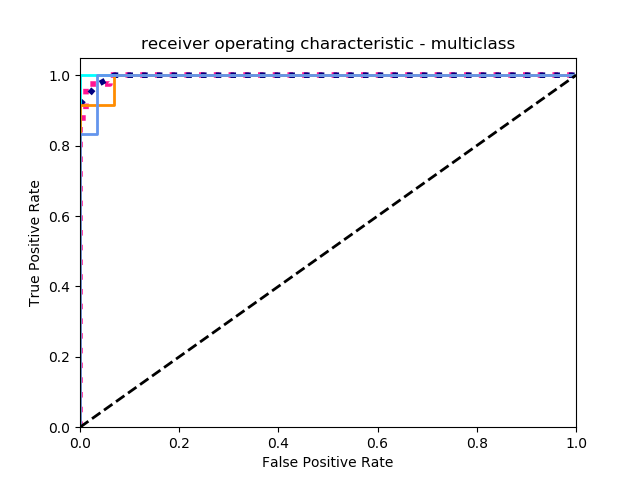

In [31]:
display_dataitem(train_run.outputs['confusion-matrix'])
display_dataitem(train_run.outputs['precision-recall-multiclass'])
display_dataitem(train_run.outputs['roc-multiclass'])

## Step 7: Serve Your Model

Add to your project a real-time model-server function (`serving`) via the [`model_server`](https://github.com/mlrun/functions/tree/master/model_server) MLRun marketplace function.

In [32]:
serving = mlrun.import_function('hub://v2_model_server').apply(auto_mount())

<a id="gs-deploy-serving-function"></a>

### Deploy the Serving Function

Set the trained model and deploy the serving function.

In [33]:
model_name = 'iris'

In [34]:
serving.add_model(model_name, train_run.outputs['model'])
function_address = serving.deploy(project=project_name)

> 2021-04-07 08:41:45,795 [info] Starting remote function deploy
2021-04-07 08:41:45  (info) Deploying function
2021-04-07 08:41:45  (info) Building
2021-04-07 08:41:45  (info) Staging files and preparing base images
2021-04-07 08:41:45  (info) Building processor image
2021-04-07 08:41:50  (info) Build complete
2021-04-07 08:41:58  (info) Function deploy complete
> 2021-04-07 08:41:58,823 [info] function deployed, address=default-tenant.app.ynrhpeobmpbb.iguazio-cd1.com:31909


You can now run the model-serving function.
MLRun leverages Nuclio on Kubernetes: Nuclio scales up and down automatically and scales to zero when unused.
Therefore, unlike virtual machines (VMs) that consume resources and require you to delete the endpoint when unused, here you don't need to worry about deleting this serving function because of resource costs.

### Testing the Model Server

Test your model server by sending data for inference.
The `invoke` serving-function method enables programmatic testing of the serving function.
For model inference (predictions), specify the model name followed by `infer`:
```
/v2/models/{model_name}/infer
```
For complete model-service API commands &mdash; such as for list models (`models`), get model health (`ready`), and model explanation (`explain`) &mdash; see the [MLRun documentation](https://github.com/mlrun/mlrun/blob/release/v0.6.x-latest/mlrun/serving/README.md#model-server-api).

In [35]:
my_data = [[5.1, 3.5, 1.4, 0.2],
           [7.7, 3.8, 6.7, 2.2]
          ]

In [36]:
serving.invoke(f"/v2/models/{model_name}/infer", {'inputs': my_data})

{'id': '3f37d49b-e468-4f68-b3e3-9da68df6b987',
 'model_name': 'iris',
 'outputs': [0, 2]}

<a id="gs-test-model-from-notebook"></a>

### Test the Model using HTTP

In [37]:
import requests
import json
resp = requests.put(function_address, json=json.dumps({'inputs': my_data}))
print(resp.text)

{"id": "d319497e-066d-415a-9113-7333036188ce", "model_name": "iris", "outputs": [0, 2]}


## Step 8: Viewing the Nuclio Serving Function on the Dashboard

On the **Projects** dashboad page, select the project and then select "Real-time functions (Nuclio)".

<img src="./images/nuclio-deploy.png" alt="Nuclio" width="800"/>

## Step 9: Setting-up a Workflow

To run a pipeline, you first need to create a Python project object and import the required functions for its execution.

In [38]:
project_path = path.abspath('conf')
project = mlrun.new_project(project_name_base,
                            context=project_path,
                            init_git=True,
                            user_project=True)

print(f'Project path: {project_path}\nProject name: {project.name}')

Project path: /User/iguazio-platform-demo/conf
Project name: platform-demo-admin


In [39]:
project.set_function(data_prep_func)
project.set_function(describe)
project.set_function(train)
project.set_function(serving)

### Using Kubeflow Pipelines

You're now ready to create a full ML pipeline.
This is done by using [Kubeflow Pipelines](https://www.kubeflow.org/docs/pipelines/overview/pipelines-overview/) &mdash;
an open-source framework for building and deploying portable, scalable machine-learning workflows based on Docker containers.
MLRun leverages this framework to take your existing code and deploy it as steps in the pipeline.

> **Note:** When using the Iguazio Data Science Platform, Kubeflow Pipelines is available as a default (pre-deployed) shared platform service.

In [40]:
%%writefile {path.join(project_path, 'workflow.py')}

from kfp import dsl
from mlrun.platforms import auto_mount


funcs = {}
DATASET = 'cleaned_data'
LABELS = "label"
MODELS = ["sklearn.ensemble.RandomForestClassifier",
          "sklearn.linear_model.LogisticRegression",
          "sklearn.ensemble.AdaBoostClassifier"]

# Configure function resources and local settings
def init_functions(functions: dict, project=None, secrets=None):
    for f in functions.values():
        f.apply(auto_mount())

# Create a Kubeflow Pipelines pipeline
@dsl.pipeline(
    name="Getting-started-tutorial",
    description="This tutorial is designed to demonstrate some of the main "
                "capabilities of the Iguazio Data Science Platform.\n"
                "The tutorial uses the Iris flower data set."
)
def kfpipeline(source_url='https://s3.wasabisys.com/iguazio/data/iris/iris_dataset.csv'):

    # Ingest the data set
    ingest = funcs['prep-data'].as_step(
        name="prep-data",
        handler='prep_data',
        inputs={'source_url': source_url},
        params={'label_column': LABELS},
        outputs=[DATASET])
    
    # Train a model   
    train = funcs["sklearn-classifier"].as_step(
        name="train",
        params={"sample": -1,
                "label_column": LABELS,
                "test_size": 0.10},
        hyperparams={'model_pkg_class': MODELS},
        selector='max.accuracy',
        inputs={"dataset": ingest.outputs[DATASET]},
        outputs=['model', 'test_set'])
    
    # Test and visualize the model
#    test = funcs["test"].as_step(
#        name="test",
#        params={"label_column": LABELS},
#        inputs={"models_path": train.outputs['model'],
#                "test_set": train.outputs['test_set']})
    
    # Deploy the model as a serverless function
    deploy = funcs["v2-model-server"].deploy_step(
        models={"iris": train.outputs['model']})

Writing /User/iguazio-platform-demo/conf/workflow.py


<a id="gs-tutorial-4-step-register-workflow"></a>

### Registering the Workflow

Use the `set_workflow` MLRun project method to register your workflow with MLRun.
The following code sets the `name` parameter to the selected workflow name ("main") and the `code` parameter to the name of the workflow file that is found in your project directory (**workflow.py**).

In [41]:
# Register the workflow file as "main"
project.set_workflow('main', 'workflow.py')

<a id="gs-tutorial-4-step-save-project"></a>

### Saving Your Project

Run the following code to save your project:

In [42]:
project.save()

Use the `run` MLRun project method to execute your workflow pipeline with Kubeflow Pipelines.

The `run` method returns the ID of the executed workflow, which the code stores in a `run_id` variable.
You can use this ID to track the progress or your workflow, as demonstrated in the following sections.

> **Note**: You can also run the workflow from a command-line shell by using the `mlrun` CLI.
> The following CLI command defines a similar execution logic as that of the `run` call in the tutorial:
> ```
> mlrun project /User/getting-started-tutorial/conf -r main -p "$V3IO_HOME_URL/getting-started-tutorial/pipeline/{{workflow.uid}}/"
> ```

In [43]:
from os import path
from mlrun import mlconf

In [44]:
pipeline_path = mlconf.artifact_path

run_id = project.run(
    'main',
    arguments={}, 
    artifact_path=path.join(pipeline_path, "pipeline", '{{workflow.uid}}'),
    dirty=True,
    watch=True)

> 2021-04-07 08:41:59,301 [info] using in-cluster config.


> 2021-04-07 08:41:59,611 [info] Pipeline run id=b92a8cbb-c783-444f-8341-641300b04165, check UI or DB for progress
> 2021-04-07 08:41:59,611 [info] waiting for pipeline run completion


uid,start,state,name,results,artifacts
...8bd13d09,Apr 07 08:42:21,completed,train,best_iteration=1accuracy=0.975609756097561test-error=0.024390243902439025auc-micro=0.9976204640095182auc-weighted=0.9966358284272497f1-score=0.9721739130434783precision_score=0.9743589743589745recall_score=0.9722222222222222,test_setconfusion-matrixfeature-importancesprecision-recall-multiclassroc-multiclassmodeliteration_results
...1f91f5d5,Apr 07 08:42:08,completed,prep-data,num_rows=150,cleaned_data


<a id="gs-tutorial-4-step-ui-pipeline-view"></a>

## Step 10 Viewing the Pipeline on the Dashboard (UI)

Navigate to the **Pipelines** page on the dashboard (UI).
After the pipelines execution completes, you should be able to view the pipeline and see its functions: 

- `prep-data`
- `train`
- `deploy-v2-model-server`

<img src="./images/kubeflow-pipeline.png" alt="pipeline" width="600"/>